In [1]:
from PIL import Image

def img_rotate_and_scale(filename, min_angle=0,max_angle=180, scale=1, scale_id=None, scale_range=None):
  src =  Image.open(f'../source/images/{filename}.png')
  for i in range(min_angle,max_angle+1):
    angle = i
    name = f'../source/images/generated/{filename}-table-{i-min_angle+1}.png'
    dst = src.rotate(angle, resample=Image.NEAREST, expand=True, fillcolor=0)
    if scale_id is not None:
      width,height = dst.size
      dst = dst.resize((int(scale * width), int(scale*height)),resample=Image.NEAREST)
      name = f'../source/images/generated/{filename}-table-{(i-min_angle)*scale_range + scale_id+1}.png'
    dst = dst.crop(dst.getbbox())
    
    dst.save(name,bits=1,optimize=False)

def img_scale(src, scale, scale_id, filename):
  name = f'../source/images/generated/{filename}-table-{scale_id+1}.png'
  width,height = src.size
  dst = src.resize((int(scale * width), int(scale*height)),resample=Image.NEAREST)    
  dst.save(name,bits=8,optimize=False)

In [2]:
max_scale_factor = 2

Unique scales: 16


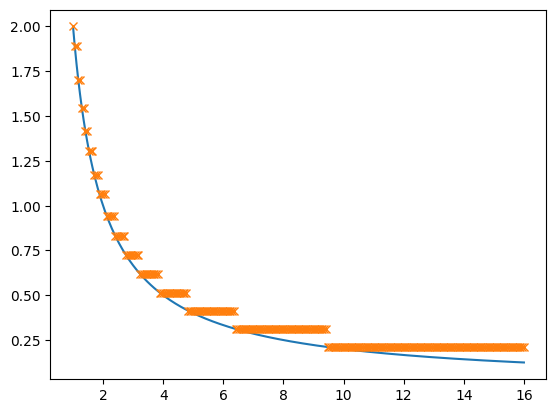

In [3]:
import matplotlib.pyplot as plt
import numpy as np

x = np.linspace(1,16,num=256)
y = max_scale_factor/x

plt.plot(x,y,'-')

prev_scale = 5000
scales = []
count = 0
for scale in y:
  # keep values significantly different from previous
  if prev_scale-scale>0.1:
    prev_scale = scale
    count += 1
  scales.append(prev_scale)

print(f"Unique scales: {count}")
plt.plot(x,scales,'x')


In [4]:
import os
import numpy as np

os.makedirs("../source/images/generated",exist_ok=True)

# compute optimal number of sprites
x = np.linspace(1,16,num=256)
prev_scale = 5000
scales = []
scale_ids = []
unique_scales = []
for scale in max_scale_factor/x:
  # keep values significantly different from previous
  if prev_scale-scale>0.1:
    prev_scale = scale
    unique_scales.append(scale)
  scale_ids.append(len(unique_scales)-1)
  scales.append(prev_scale)

unique_scales_count = len(unique_scales)
print(f"Unique scales: {unique_scales_count}")
# generate header file
with open("../lib3d/scales.h","w") as f:
  f.write(f'''
#ifndef _scales_h
#define _scales_h
#include <stdint.h>
/*
* generated - DO NOT EDIT
*/

// number of scaled images          
#define _scaled_image_count {unique_scales_count}
#define _scaled_image_min_angle -30
#define _scaled_image_max_angle 30
// 1/z to scale id
static const uint8_t _scaled_by_z[{len(scale_ids)}]={{{",".join(map(str,scale_ids))}}};
#endif
''')


Unique scales: 16


In [5]:

# full rotation images
for filename in ["tumbling"]:
  img_rotate_and_scale(filename,min_angle=0,max_angle=359)

for filename in ["pine_snow_0","checkpoint_left"]:
  for i,scale in enumerate(unique_scales):
    img_rotate_and_scale(filename,min_angle=-30,max_angle=31,scale=scale, scale_id=i, scale_range=unique_scales_count)


In [8]:

# animated coins
coins =  Image.open(f'../source/images/coin-strip.png')
for i in range(5):
  src = coins.crop((i*16,0,i*16+16,16))
  for k,s in enumerate(unique_scales):
    img_scale(src,2*s,i*unique_scales_count + k,"coin")

In [7]:
from PIL import Image,ImageDraw
import math

# skybox
src =  Image.open('./sky_background_raw_inverted_simple.png')
src = src.convert('RGBA')
src_width, src_height = src.size
for i in range(-30,31):
    angle = i
    # find extent
    dst = src.rotate(angle, resample=Image.BICUBIC, expand=True, fillcolor=(255,255,255,0))
    width, height = dst.size
    # find min/max height
    nx, ny = math.cos(angle * math.pi / 180), math.sin(angle * math.pi / 180)
    nx, ny = ny, -nx    
    extents = []
    for delta in [src_height/2,-src_height/2]:
      miny, maxy = math.inf, -math.inf
      extent = []
      for x in [-200,200]:        
          Nx, Ny = delta * nx, delta * ny
          t = (Nx - x) / ny
          y = Ny + t * nx
          extent.append(height/2+y)    
      extents.append(extent)
    top, bottom = min(extents[0]), max(extents[1])
    dst = dst.crop((width/2-200,top,width/2+200,bottom))
    width, height = dst.size
    img = Image.new('RGBA',size=(width,height),color=(255,255,255))
    draw = ImageDraw.Draw(img)
    draw.rectangle((0,0,width,height/2),fill=(255,255,255),width=0)
    img.alpha_composite(dst,(0,0))
    img = img.convert(mode="1")
    img.save(f'../source/images/generated/sky_background-table-{i+30+1}.png',bits=1,optimize=False)